<a href="https://colab.research.google.com/github/datasigntist/deeplearning/blob/master/deepNeuralNetworks_LogisticRegression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Author**: Vishwanathan Raman
**Email**: datasigntist@gmail.com


---


**Change History**


*   1-Jan-2018 -- Initial Creation
*   14-Aug-2019 -- Included detailed comments for each step


---

**Credits**
The code articulated here has been inspired from coursera deeplearning.ai Assignments


---

**Use Case Description**

This notebook develops a Deep Neural Network to solve the Classification problem using Logistic Regression. A Deep Neural Network has multiple layers having multiple nodes through which input is processed.The dataset (.h5) is a collection of Cat Images. The data files needs to be uploaded to the Files section in the colab environment.  The library  h5py package (https://www.h5py.org/) is a Pythonic interface to the HDF5 binary data format. Each Image is a collection of R,G,B pixel intensity values represented as matrices, also called channels. The pixel intensity values are the features that defines the Image. Each Image is represented as a single vector of pixel intensity values.




*   Train dataset : https://github.com/datasigntist/datasetsForTraining/blob/master/train_catvnoncat.h5
*   Test dataset  : https://github.com/datasigntist/datasetsForTraining/blob/master/test_catvnoncat.h5



---


**Other Learning Resources**

The following youtube playlist lists all the concepts related to Deep Learning 

https://www.youtube.com/playlist?list=PLkDaE6sCZn6Ec-XTbcX1uRg2_u4xOEky0

https://www.youtube.com/playlist?list=PLkDaE6sCZn6Hn0vK8co82zjQtt3T2Nkqc


The following represents a 3 layer neural network representation having 2 hidden layers and 1 output layer.

![alt text](https://raw.githubusercontent.com/datasigntist/imagesforNotebook/master/Neural%20Network%20Representation.png)

In [0]:
# Load the libraries
import time
import numpy as np
import h5py
import matplotlib.pyplot as plt
import scipy
from PIL import Image
from scipy import ndimage

%matplotlib inline
plt.rcParams['figure.figsize'] = (5.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

np.random.seed(1)

In [0]:
def sigmoid(Z):
    """
    Implements the sigmoid activation in numpy
    
    Arguments:
    Z -- numpy array of any shape
    
    Returns:
    A -- output of sigmoid(z), same shape as Z
    cache -- returns Z as well, useful during backpropagation
    """
    
    A = 1/(1+np.exp(-Z))
    cache = Z
    
    return A, cache

def sigmoid_backward(dA, cache):
    """
    Implement the backward propagation for a single SIGMOID unit.

    Arguments:
    dA -- post-activation gradient, of any shape
    cache -- 'Z' where we store for computing backward propagation efficiently

    Returns:
    dZ -- Gradient of the cost with respect to Z
    """
    
    Z = cache
    
    s = 1/(1+np.exp(-Z))
    dZ = dA * s * (1-s)
    
    assert (dZ.shape == Z.shape)
    
    return dZ


def load_data():
    train_dataset = h5py.File('train_catvnoncat.h5', "r")
    train_set_x_orig = np.array(train_dataset["train_set_x"][:]) # your train set features
    train_set_y_orig = np.array(train_dataset["train_set_y"][:]) # your train set labels

    test_dataset = h5py.File('test_catvnoncat.h5', "r")
    test_set_x_orig = np.array(test_dataset["test_set_x"][:]) # your test set features
    test_set_y_orig = np.array(test_dataset["test_set_y"][:]) # your test set labels

    classes = np.array(test_dataset["list_classes"][:]) # the list of classes
    
    train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
    test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))
    
    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes

In [0]:
# Load the data
train_x_orig, train_y, test_x_orig, test_y, classes = load_data()

y = 0. It's a non-cat picture.


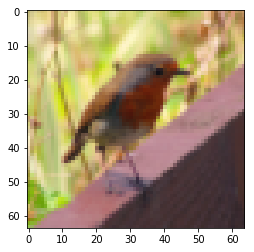

In [0]:
# Example of a picture
index = 10
plt.imshow(train_x_orig[index])
print ("y = " + str(train_y[0,index]) + ". It's a " + classes[train_y[0,index]].decode("utf-8") +  " picture.")

In [0]:
# Explore your dataset 
# Number of training examples
m_train = train_x_orig.shape[0]
# Size of the image in pixels
num_px = train_x_orig.shape[1]
# Number of test examples
m_test = test_x_orig.shape[0]

print ("Number of training examples: " + str(m_train))
print ("Number of testing examples: " + str(m_test))
print ("Each image is of size: (" + str(num_px) + ", " + str(num_px) + ", 3)")
print ("train_x_orig shape: " + str(train_x_orig.shape))
print ("train_y shape: " + str(train_y.shape))
print ("test_x_orig shape: " + str(test_x_orig.shape))
print ("test_y shape: " + str(test_y.shape))

Number of training examples: 209
Number of testing examples: 50
Each image is of size: (64, 64, 3)
train_x_orig shape: (209, 64, 64, 3)
train_y shape: (1, 209)
test_x_orig shape: (50, 64, 64, 3)
test_y shape: (1, 50)


In [0]:
# Reshape the training and test examples 
# The "-1" makes reshape flatten the remaining dimensions
train_x_flatten = train_x_orig.reshape(train_x_orig.shape[0], -1).T   
test_x_flatten = test_x_orig.reshape(test_x_orig.shape[0], -1).T

# Standardize data to have feature values between 0 and 1.
train_x = train_x_flatten/255.
test_x = test_x_flatten/255.

print ("train_x's shape: " + str(train_x.shape))
print ("test_x's shape: " + str(test_x.shape))

train_x's shape: (12288, 209)
test_x's shape: (12288, 50)


initialize_param_deep_nn is a function that outlines the layers within the neural network. Each layer has a collection of nodes and each node has a linear and an activation component. Each layer has its own set of parameters W and b. The function initializes W to a set of random values.

![alt text](https://raw.githubusercontent.com/datasigntist/imagesforNotebook/master/Layer%20Definition%20and%20Initialization.png)

In [0]:
def initialize_param_deep_nn(layer_dims):
    """
        layer_dims defines the number of nodes in each layer starting from the input to the output
        
        Each layer (minus the input layer) has 2 parameters
            W : The Weights has a shape of (n[l],n[l-1]), its initialized to random values
            b : The bias is a vector of real numbers. Its of shape (n[l],1), its initialized to all 0s
    """
    
    np.random.seed(1)
    parameters = {}
    L = len(layer_dims)            # number of layers in the network
    
    for l in range(1,L):
        parameters["W" + str(l)] = np.random.randn(layer_dims[l],layer_dims[l-1]) / np.sqrt(layer_dims[l-1])
        parameters["b" + str(l)] = np.zeros((layer_dims[l],1))
        
    return parameters

In [0]:
# Create a 3 layer neural network having 
# 12288 features in the input layer
# 2 hidden layers
# The 1st hidden layer has 2 nodes
# The 2nd hidden layer has 3 nodes
# 1 output node since we are solving the problem of binary classification

layer_dims = [train_x.shape[0],2,3,1]
parameters = initialize_param_deep_nn(layer_dims)

L = len(layer_dims)
for l in range(1,L):
    print("shape of W"+str(l)+" is "+str(parameters["W"+str(l)].shape))
    print("shape of b"+str(l)+" is "+str(parameters["b"+str(l)].shape))

shape of W1 is (2, 12288)
shape of b1 is (2, 1)
shape of W2 is (3, 2)
shape of b2 is (3, 1)
shape of W3 is (1, 3)
shape of b3 is (1, 1)


A representation of forward and backward computation across the layers

![alt text](https://raw.githubusercontent.com/datasigntist/imagesforNotebook/master/Forward%20and%20Backward%20Computation.png)

In [0]:
# Develop the forward propagation
# linear_forward 
# linear_activation_forward
# L_model_forward
def linear_forward(A, W, b):
    """
        A_prev : the input layer
        W and b : the parameters
        Z : the output of the linear function
        cache the values of A, W, b, this will be used during backward propagation
    """
    
    Z = np.dot(W, A) + b
    cache = (A, W, b)
    
    return Z, cache

In [0]:
def linear_activation_forward(A, W, b, activation):
    """
        Calls the linear_forward for applying the linear function
        Applies activation on top of the linear function, here activation is passed as a string
    """
    
    if activation == "sigmoid":
        Z, linear_cache = linear_forward(A, W, b)
        A, activation_cache = sigmoid(Z)
        
    cache = (linear_cache, activation_cache)  
        
    return A, cache

In [0]:
def L_model_forward(X, parameters):
    """
        Does the forward propagation across the layers
        
        The final output is defined as AL
    """
    
    caches = []
    A = X
    L = len(parameters)//2
    
    # The loop executes the forward propagation across the layer. Each layer outputs A which is passed as an input
    # to the next layer. The input to the first layer is the input X
    for l in range(1,L):
        A_prev = A
        A, cache = linear_activation_forward(A_prev, parameters["W"+str(l)], parameters["b"+str(l)], "sigmoid")
        caches.append(cache)
        
    AL, cache = linear_activation_forward(A, parameters["W"+str(L)], parameters["b"+str(L)], "sigmoid")
    caches.append(cache)
        
    return AL, caches

In [0]:
def compute_cost(AL, Y):
    """
        In the current scenario, the sigmoid function is used in the final output layer
    """
    
    m = Y.shape[1] 
    cost = (1./m) * (-np.dot(Y,np.log(AL).T) - np.dot(1-Y, np.log(1-AL).T))
    
    cost = np.squeeze(cost)      # To make sure your cost's shape is what we expect (e.g. this turns [[17]] into 17).
    
    return cost

Backward Computation Illustration -- Representative Steps for a Logistic Regression

![alt text](https://raw.githubusercontent.com/datasigntist/imagesforNotebook/master/Backward%20Computation%20--%201.png)

![alt text](https://raw.githubusercontent.com/datasigntist/imagesforNotebook/master/Backward%20Computation%20--%202.png)

![alt text](https://raw.githubusercontent.com/datasigntist/imagesforNotebook/master/Backward%20Computation%20--%203.png)

![alt text](https://raw.githubusercontent.com/datasigntist/imagesforNotebook/master/Backward%20Computation%20--%204.png)

![alt text](https://raw.githubusercontent.com/datasigntist/imagesforNotebook/master/Backward%20Computation%20--%205.png)

In [0]:
# Develop the backward propagation
# linear_backward 
# linear_activation_backward
# L_model_backward
def linear_backward(dZ, cache):
    """
        calculates the following
        dW, db, dA
    """
    
    A_prev, W, b = cache
    m = A_prev.shape[1]
    
    dW = 1./m*np.dot(dZ, A_prev.T)
    db = 1./m*np.sum(dZ, axis = 1, keepdims = True)
    dA_prev = np.dot(W.T, dZ)
    
    return dA_prev, dW, db

In [0]:
def linear_activation_backward(dA, cache, activation):
    """
        calculates the following
        dZ
    """
    
    linear_cache, activation_cache = cache
    
    if activation == "sigmoid":
        dZ = sigmoid_backward(dA, activation_cache)
        dA_prev, dW, db = linear_backward(dZ, linear_cache)
    
    return dA_prev, dW, db

In [0]:
def L_model_backward(AL, Y, caches):
    """
    Implement the backward propagation 
    
    Arguments:
    AL -- probability vector, output of the forward propagation (L_model_forward())
    Y -- true "label" vector (containing 0 if non-cat, 1 if cat)
    caches -- list of caches containing:
                every cache of linear_activation_forward() with "relu" (there are (L-1) or them, indexes from 0 to L-2)
                the cache of linear_activation_forward() with "sigmoid" (there is one, index L-1)
    
    Returns:
    grads -- A dictionary with the gradients
             grads["dA" + str(l)] = ... 
             grads["dW" + str(l)] = ...
             grads["db" + str(l)] = ... 
    """
    grads = {}
    L = len(caches) # the number of layers
    m = AL.shape[1]
    Y = Y.reshape(AL.shape) # after this line, Y is the same shape as AL
    
    # Initializing the backpropagation
    dAL = - (np.divide(Y, AL) - np.divide(1 - Y, 1 - AL))
    
    current_cache = caches[L-1]
    grads["dA" + str(L)], grads["dW" + str(L)], grads["db" + str(L)] = linear_activation_backward(dAL, current_cache, activation = "sigmoid")
    
    for l in reversed(range(L-1)):
        current_cache = caches[l]
        dA_prev_temp, dW_temp, db_temp = linear_activation_backward(grads["dA" + str(l + 2)], current_cache, activation = "sigmoid")
        grads["dA" + str(l + 1)] = dA_prev_temp
        grads["dW" + str(l + 1)] = dW_temp
        grads["db" + str(l + 1)] = db_temp

    return grads

In [0]:
def update_parameters(parameters, grads, learning_rate):
    """
    Update parameters using gradient descent
    
    Arguments:
    parameters -- python dictionary containing your parameters 
    grads -- python dictionary containing your gradients, output of L_model_backward
    
    Returns:
    parameters -- python dictionary containing your updated parameters 
                  parameters["W" + str(l)] = ... 
                  parameters["b" + str(l)] = ...
    """
    
    L = len(parameters) // 2 # number of layers in the neural network

    # Update rule for each parameter. Use a for loop.
    for l in range(L):
        parameters["W" + str(l+1)] = parameters["W" + str(l+1)] - learning_rate * grads["dW" + str(l+1)]
        parameters["b" + str(l+1)] = parameters["b" + str(l+1)] - learning_rate * grads["db" + str(l+1)]
        
    return parameters

In [0]:
def L_layer_model(X, Y, layers_dims, learning_rate = 0.0075, num_iterations = 3000, print_cost=False):#lr was 0.009
    """
    Implements a L-layer neural network: .
    
    Arguments:
    X -- data, numpy array of shape (number of examples, num_px * num_px * 3)
    Y -- true "label" vector (containing 0 if cat, 1 if non-cat), of shape (1, number of examples)
    layers_dims -- list containing the input size and each layer size, of length (number of layers + 1).
    learning_rate -- learning rate of the gradient descent update rule
    num_iterations -- number of iterations of the optimization loop
    print_cost -- if True, it prints the cost every 100 steps
    
    Returns:
    parameters -- parameters learnt by the model. They can then be used to predict.
    """

    np.random.seed(1)
    costs = []                         # keep track of cost
    
    # Parameters initialization.
    parameters = initialize_param_deep_nn(layers_dims)
    
    # Loop (gradient descent)
    for i in range(0, num_iterations):
        
        AL, caches = L_model_forward(X, parameters)
        
        # Compute cost.
        cost = compute_cost(AL, Y)
    
        # Backward propagation.
        grads = L_model_backward(AL, Y, caches)
 
        # Update parameters.
        parameters = update_parameters(parameters, grads, learning_rate)
                
        # Print the cost every 100 training example
        if print_cost and i % 100 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))
        if print_cost and i % 100 == 0:
            costs.append(cost)
            
    # plot the cost
    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per tens)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    
    return parameters

In [0]:
layers_dims = [12288, 2, 1,1] #  2-layer model

Cost after iteration 0: 0.746862
Cost after iteration 100: 0.707051
Cost after iteration 200: 0.684073
Cost after iteration 300: 0.669829
Cost after iteration 400: 0.660811
Cost after iteration 500: 0.655025
Cost after iteration 600: 0.651274
Cost after iteration 700: 0.648824
Cost after iteration 800: 0.647211
Cost after iteration 900: 0.646144
Cost after iteration 1000: 0.645435
Cost after iteration 1100: 0.644961
Cost after iteration 1200: 0.644644
Cost after iteration 1300: 0.644430
Cost after iteration 1400: 0.644286
Cost after iteration 1500: 0.644189
Cost after iteration 1600: 0.644122
Cost after iteration 1700: 0.644077
Cost after iteration 1800: 0.644046
Cost after iteration 1900: 0.644024
Cost after iteration 2000: 0.644009
Cost after iteration 2100: 0.643998
Cost after iteration 2200: 0.643990
Cost after iteration 2300: 0.643984
Cost after iteration 2400: 0.643979


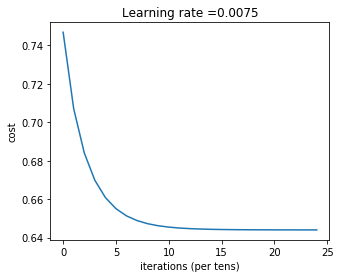

In [0]:
parameters = L_layer_model(train_x, train_y, layers_dims, num_iterations = 2500, print_cost = True)

In [0]:
def predict(X, y, parameters):
    """
    This function is used to predict the results of a  L-layer neural network.
    
    Arguments:
    X -- data set of examples you would like to label
    parameters -- parameters of the trained model
    
    Returns:
    p -- predictions for the given dataset X
    """
    
    m = X.shape[1]
    n = len(parameters) // 2 # number of layers in the neural network
    p = np.zeros((1,m))
    
    # Forward propagation
    probas, caches = L_model_forward(X, parameters)

    
    # convert probas to 0/1 predictions
    for i in range(0, probas.shape[1]):
        if probas[0,i] > 0.5:
            p[0,i] = 1
        else:
            p[0,i] = 0
    
    #print results
    #print ("predictions: " + str(p))
    #print ("true labels: " + str(y))
    print("Accuracy: "  + str(np.sum((p == y)/m)))
        
    return p

In [0]:
pred_train = predict(train_x, train_y, parameters)

Accuracy: 0.6555023923444976


In [0]:
pred_test = predict(test_x, test_y, parameters)

Accuracy: 0.3400000000000001


As next steps, 
*   You can experiment with different hyper parameters
        *  Experiment with new neural network architectures (hidden layers, nodes per hidden layer)
        *  Adjust the number of iterations
        *  Use the ReLU in the hidden layers instead of Sigmoid